# 1. 定义算法

教程中提到相比于Q learning，DQN本质上是为了适应更为复杂的环境，并且经过不断的改良迭代，到了Nature DQN（即Volodymyr Mnih发表的Nature论文）这里才算是基本完善。DQN主要改动的点有三个：

使用深度神经网络替代原来的Q表：这个很容易理解原因
使用了经验回放（Replay Buffer，见[经验回放](https://datawhalechina.github.io/easy-rl/#/chapter6/chapter6?id=_65-%e7%bb%8f%e9%aa%8c%e5%9b%9e%e6%94%be)部分）：这个好处有很多，一个是使用一堆历史数据去训练，比之前用一次就扔掉好多了，大大提高样本效率，另外一个是面试常提到的，减少样本之间的相关性，原则上获取经验跟学习阶段是分开的（个人理解，采样和价值估计是解耦的，不同策略都可以采样，价值估计的时候因为只与当前使用的价值估计网络Q有关因此什么时候估计都可以，只要有Q就能估计，这部分的理解可参考笔记部分），原来时序的训练数据有可能是不稳定的，打乱之后再学习有助于提高训练的稳定性，跟深度学习中划分训练测试集时打乱样本是一个道理。
使用了两个网络：即策略网络和目标网络，每隔若干步才把每步更新的策略网络参数复制给目标网络，这样做也是为了训练的稳定，避免Q值的估计发散。想象一下，如果当前有个transition样本（就是一次完整互动得到的四元组（s,a,r,s')，表示当前状态，动作，即时奖励和执行动作a后进入的下一个状态）导致对Q值进行了较差的过估计，如果接下来从经验回放中提取到的样本正好连续几个都这样的，很有可能导致Q值的发散（它的青春小鸟一去不回来了）。再打个比方，我们玩RPG或者闯关类游戏，有些人为了破纪录经常Save和Load，只要我出了错，我不满意我就加载之前的存档，假设不允许加载呢，就像DQN算法一样训练过程中会退不了，这时候是不是搞两个档，一个档每帧都存一下，另外一个档打了不错的结果再存，也就是若干个间隔再存一下，到最后用间隔若干步数再存的档一般都比每帧都存的档好些呢。当然你也可以再搞更多个档，也就是DQN增加多个目标网络，但是对于DQN则没有多大必要，多几个网络效果不见得会好很多。

## 1.1 定义模型
前面说了DQN的模型不再是Q表，而是一个深度神经网络，这里我只用了一个三层的全连接网络（FCN），这种网络也叫多层感知机（MLP），至于怎么用Torch写网络这里就不多说明了，以下仅供参考。

In [26]:
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self, n_states,n_actions,hidden_dim=128):
        """ 初始化q网络，为全连接网络
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_states, hidden_dim) # 输入层
        self.fc2 = nn.Linear(hidden_dim,hidden_dim * 2) # 隐藏层
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim) 
        self.fc4 = nn.Linear(hidden_dim, n_actions) # 输出层
        
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

## 1.2 定义经验回放
经验回放首先是具有一定容量的，只有存储一定的transition网络才会更新，否则就退回到了之前的逐步更新了。另外写经验回放的时候一般需要包涵两个功能或方法，一个是push，即将一个transition样本按顺序放到经验回放中，如果满了就把最开始放进去的样本挤掉，这里就按照队列来写了。另外一个是sample，很简单就是随机采样出一个或者若干个（具体多少就是batch_size了）样本供DQN网络更新。功能讲清楚了，大家可以按照自己的想法用代码来实现，参考如下。

In [3]:
from collections import deque
import random
class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        ''' 存储transition到经验回放,append在队列库的实现中是右侧放入,队列满的时候左侧的元素会被自动弹出，形成FIFO
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 随机开始位置的顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        ''' 清空经验回放
        '''
        self.buffer.clear()
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

## 1.3 真·算法
这里我们主要分析一下DQN的更新过程，也就是update函数。首先我们知道目前所有基于深度神经网络的更新方式都是梯度下降，如下：

$$\theta_i \leftarrow \theta_i - \lambda \nabla_{\theta_i} L_i(\theta_i)$$ 

那么这个$θ$又是什么呢，注意到前面我们讲的DQN跟Q learning算法的一个主要区别就是使用神经网络替代了Q表，而这个$θ$实际上就是神经网络的参数，通常用$Q(s_i, a_i; θ)$表示。根据强化学习的原理我们需要优化的是对应状态下不同动作的长期价值，然后每次选择价值最大对应的动作就能完成一条最优策略，使用神经网络表示Q表时也是如此，我们将输入的状态数作为神经网络的输入层，动作数作为输出层，这样的神经网络表达的功能就跟在Q learning中的Q表是一样的，只不过具有更强的鲁棒性（同时也可以处理连续的状态空间和动作的问题，表格会要求二者是离散的，离散的东西可以写成一张表来表示，连续的我们往往会通过一个分布或者说函数来表示）。

讲完了为什么要优化的是这个参数$θ$，接下来我们从代码层面进一步剖析，了解一点Torch知识的同学知道，上面的公式其实只需要定义一个优化器，计算损失之后用优化器迭代即可，如下：

```python
optimizer = optim.Adam(Q_net.parameters(), lr=0.01) # 定义优化器，对应的网络是Q_net，学习率为0.01
loss = ... # 计算损失，这里掠过
# 然后优化器先zero_grad()，loss再反向传播，然后优化器step() ，这是一个固定的套路
optimizer.zero_grad()  
loss.backward()
optimizer.step() 
```

细心的同学会发现数学公式和代码的对应是有一定的壁垒的，只要通过多加练习跨越了这个壁垒，那么对于往后我们想要复现论文也会轻松许多。我们目前讲了参数的更新过程，但是最关键的是损失是如何计算的，在DQN中损失的计算相对来说比较简单，如下：

$$
L(\theta) = (y_i - Q(s_i, a_i; \theta))^2
$$

这里的$y_i$通常称为期望值，$Q(s_i, a_i; \theta)$称为实际值，这个损失在深度学习中通常称作均方差损失，也就是mseloss，使用这个损失函数通常追溯到数学上的最小二乘法，感兴趣的同学可以了解一下深度学习中的各种损失函数以及各自的使用场景。$y_i$在DQN中一般表示如下：

$$
y_i = 
\begin{cases} 
r_i & \text{对于终止状态 } s_{i+1} \\
r_i + \gamma \max_{a'} Q(s_{i+1}, a'; \theta) & \text{对于非终止状态 } s_{i+1}
\end{cases}
$$

该公式的意思就是将下一个状态对应的最大Q值作为实际值（因为实际值通常不能直接求得，只能近似，对应书中的这个部分[目标网络](https://datawhalechina.github.io/easy-rl/#/chapter6/chapter6?id=_63-%e7%9b%ae%e6%a0%87%e7%bd%91%e7%bb%9c)，这里书中写的好像和非终止状态是一样的，但是要理解这里的含义就是用即时奖励加上对后续的整体奖励的估计，那么当后续没有奖励时，显然就不需要整体奖励的估计了，这里要灵活理解公式含义。个人觉得这里的更新和前面的时序差分的思路是一样的，只要把时序差分弄明白这里就好懂了，时序差分可见[时序差分](https://datawhalechina.github.io/easy-rl/#/chapter3/chapter3?id=_332-%e6%97%b6%e5%ba%8f%e5%b7%ae%e5%88%86)），这种做法实际上只是一种近似，可能会导致过估计等问题，也有一些改善的方法具体可以在后面各种改进的DQN算法比如Double DQN中看到。

这里使用了$\epsilon-greedy$策略，即有$\epsilon$的概率采用随机的动作，$1-\epsilon$的概率按照策略网络的价值判断来采用价值最大的动作，这里$\epsilon$可以随时间衰减。这个策略可参考书中的[e-greedy](https://datawhalechina.github.io/easy-rl/#/chapter3/chapter3?id=_333-%e5%8a%a8%e6%80%81%e8%a7%84%e5%88%92%e6%96%b9%e6%b3%95%e3%80%81%e8%92%99%e7%89%b9%e5%8d%a1%e6%b4%9b%e6%96%b9%e6%b3%95%e4%bb%a5%e5%8f%8a%e6%97%b6%e5%ba%8f%e5%b7%ae%e5%88%86%e6%96%b9%e6%b3%95%e7%9a%84%e8%87%aa%e4%b8%be%e5%92%8c%e9%87%87%e6%a0%b7:~:text=%E4%B8%BA%E4%BA%86%E7%A1%AE%E4%BF%9D%E8%92%99%E7%89%B9,%EF%BC%89%E6%8E%A2%E7%B4%A2)。这里策略网络和目标网络先用同一个model初始化后，


In [14]:
import torch
import torch.optim as optim
import math
import numpy as np
import copy
class DQN:
    def __init__(self,model,memory,cfg):

        self.n_actions = cfg['n_actions']  
        self.device = torch.device(cfg['device']) 
        self.gamma = cfg['gamma'] # 奖励的折扣因子
        # e-greedy策略相关参数 这里
        self.sample_count = 0  # 用于epsilon的衰减计数
        self.epsilon = cfg['epsilon_start']
        self.sample_count = 0  
        self.epsilon_start = cfg['epsilon_start']
        self.epsilon_end = cfg['epsilon_end']
        self.epsilon_decay = cfg['epsilon_decay']
        self.batch_size = cfg['batch_size']
        self.policy_net = model.to(self.device)
        # 这里改用深拷贝创建一个新的独立网络并拥有自己独立的内存空间 
        self.target_net = copy.deepcopy(self.policy_net)
        # 原始代码，有指向同一个实例化模型的嫌疑，这里为了保险改用深拷贝
        # self.target_net = model.to(self.device)
        # 复制参数到目标网络
        # for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): 
            #target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg['lr']) # 优化器
        self.memory = memory # 经验回放
    def sample_action(self, state):
        ''' 采样动作
        '''
        self.sample_count += 1
        # epsilon指数衰减
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if random.random() > self.epsilon:
            return self.predict_action(state)
        else:
            return random.randrange(self.n_actions)
    @torch.no_grad() # 不计算梯度，该装饰器效果等同于with torch.no_grad()： 这里仅仅是采样，是运行一下策略网络，不是来优化策略网络的，所以不要计算梯度
    def predict_action(self, state):
        ''' 预测动作
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        q_values = self.policy_net(state)
        action = q_values.max(1)[1].item() # choose action corresponding to the maximum q value
        return action
    def update(self):
        if len(self.memory) < self.batch_size: # 当经验回放中不满足一个批量时，不更新策略
            return
        # 从经验回放中随机采样一个批量的转移(transition) 注意此处对应着标准的四元组 加上一个done表示某一步采样是否正好结束状态
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        # 将数据转换为tensor
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)  # 转换成state一样的形状 不然就是一维的batch batch每个样本对应的动作
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float)  
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device)
        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch) # 计算当前状态(s_t,a)对应的Q(s_t, a)
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach() # 计算下一时刻的状态(s_t_,a)对应的Q值
        # 计算期望的Q值，对于终止状态，此时done_batch[0]=1, 对应的expected_q_value等于reward
        expected_q_values = reward_batch + self.gamma * next_q_values * (1-done_batch)
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))  # 计算均方根损失
        # 优化更新模型
        self.optimizer.zero_grad()  
        loss.backward()
        # clip防止梯度爆炸
        for param in self.policy_net.parameters():  
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 

## 2 定义训练

适配了新版的api（如seed的传入位置，reset的新返回值和step的新返回值），增加了测试时的录制功能，会录制一个视频来记录测试过程 

In [15]:
from gymnasium.wrappers import RecordVideo
from IPython.display import Video, display
import glob
import gymnasium as gym
import os

def train(cfg, env, agent):
    print("开始训练！")
    rewards = []
    steps = []

    # 设置动作空间seed
    if cfg.get('seed', None) is not None:
        env.action_space.seed(cfg['seed'])
        
    for i_ep in range(cfg['train_eps']):
        ep_reward = 0.0
        ep_step = 0
        # Gymnasium 的 reset 返回 (obs, info) 并在此处加入seed参数
        state, _ = env.reset(seed=cfg.get('seed', None))
        for _ in range(cfg['ep_max_steps']):
            ep_step += 1
            action = agent.sample_action(state)
            # Gymnasium 的 step 返回 5 元组
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.memory.push((state, action, reward, next_state, done))
            state = next_state
            agent.update()
            ep_reward += reward
            if done:
                break

        if (i_ep + 1) % cfg['target_update'] == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg['train_eps']}，奖励：{ep_reward:.2f}，Epislon：{agent.epsilon:.3f}")

    print("完成训练！")
    env.close()
    return {'rewards': rewards}

# 增加了录制最终测试时的场景视频并播放的功能
def test_and_record(cfg, agent, video_dir='./videos', name_prefix='dqn-test'):
    os.makedirs(video_dir, exist_ok=True)
    # 仅用于录制的环境：必须用 rgb_array
    env = gym.make(cfg['env_name'], render_mode='rgb_array')
    # 可选：设置随机种子
    seed = cfg.get('seed', None)
    if seed is not None:
        env.action_space.seed(seed)
    # 只录制最后一集
    env = RecordVideo(
        env,
        video_folder=video_dir,
        name_prefix=name_prefix,
        episode_trigger=lambda ep_id: ep_id == cfg['test_eps'] - 1
    )
    print("开始测试并录制视频！")
    rewards = []
    for i_ep in range(cfg['test_eps']):
        state, _ = env.reset(seed=seed)
        ep_reward = 0.0
        for _ in range(cfg['ep_max_steps']):
            action = agent.predict_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_reward += reward
            state = next_state
            if terminated or truncated:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg['test_eps']}，奖励：{ep_reward:.2f}")
    env.close()
    print("完成测试与录制")
    # 只查找本次 name_prefix 下的 mp4，避免历史文件干扰
    mp4s = sorted(glob.glob(os.path.join(video_dir, f'{name_prefix}*.mp4')))
    if mp4s:
        print(f"视频文件：{mp4s[-1]}")
        display(Video(mp4s[-1], embed=True))
    else:
        print(f"未找到视频文件，请检查目录：{video_dir} 或确认已安装 imageio 和 imageio-ffmpeg")
    return {'rewards': rewards, 'video_path': (mp4s[-1] if mp4s else None)}


## 3 定义环境
此处因为gym包更新为gymnasium，因此需要对之前使用gym包环境定义进行一些改动

In [16]:
import gymnasium as gym
import os
# 让所有的随机种子都使用同一个数
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    # 新版已经舍弃 env.seed 需要在env.reset还有env.observation_space和action_space中单独传入seed参数
    # env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn 不用也可以 这里是保证100%可复现
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg['env_name']) # 创建环境
    if cfg['seed'] !=0:
        all_seed(env,seed=cfg['seed'])
    n_states = env.observation_space.shape[0]
    # 注意 属性n在离散动作空间的情况下才有 连续动作空间没有这个属性
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    cfg.update({"n_states":n_states,"n_actions":n_actions}) # 更新n_states和n_actions到cfg参数中
    model = MLP(n_states, n_actions, hidden_dim = cfg['hidden_dim']) # 创建模型
    memory = ReplayBuffer(cfg['memory_capacity'])
    agent = DQN(model,memory,cfg)
    return env,agent

## 4 设置参数

In [30]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
def get_args():
    """ 超参数 可以自己调整超参数或使用不同的网络结构玩一下 
    """
    parser = argparse.ArgumentParser(description="hyperparameters")      
    parser.add_argument('--algo_name',default='DQN',type=str,help="name of algorithm")
    # 注意 新版gym中 改为了CartPole-v1 v0已经弃用
    parser.add_argument('--env_name',default='CartPole-v1',type=str,help="name of environment")
    parser.add_argument('--train_eps',default=90,type=int,help="episodes of training")
    parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing")
    parser.add_argument('--ep_max_steps',default = 100000,type=int,help="steps per episode, much larger value can simulate infinite steps")
    parser.add_argument('--gamma',default=0.95,type=float,help="discounted factor")
    parser.add_argument('--epsilon_start',default=0.95,type=float,help="initial value of epsilon")
    parser.add_argument('--epsilon_end',default=0.01,type=float,help="final value of epsilon")
    parser.add_argument('--epsilon_decay',default=500,type=int,help="decay rate of epsilon, the higher value, the slower decay")
    parser.add_argument('--lr',default=0.0001,type=float,help="learning rate")
    parser.add_argument('--memory_capacity',default=100000,type=int,help="memory capacity")
    parser.add_argument('--batch_size',default=64,type=int)
    parser.add_argument('--target_update',default=4,type=int)
    parser.add_argument('--hidden_dim',default=256,type=int)
    parser.add_argument('--device',default='cuda',type=str,help="cpu or cuda") 
    parser.add_argument('--seed',default=10,type=int,help="seed")   
    args = parser.parse_args([])
    args = {**vars(args)}  # 转换成字典类型    
    ## 打印超参数
    print("超参数")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in args.items():
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))      
    return args
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg['device']} of {cfg['algo_name']} for {cfg['env_name']}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()

## 5 开始训练

超参数
        Name        	       Value        	        Type        
     algo_name      	        DQN         	   <class 'str'>    
      env_name      	    CartPole-v1     	   <class 'str'>    
     train_eps      	         90         	   <class 'int'>    
      test_eps      	         20         	   <class 'int'>    
    ep_max_steps    	       100000       	   <class 'int'>    
       gamma        	        0.95        	  <class 'float'>   
   epsilon_start    	        0.95        	  <class 'float'>   
    epsilon_end     	        0.01        	  <class 'float'>   
   epsilon_decay    	        500         	   <class 'int'>    
         lr         	       0.0001       	  <class 'float'>   
  memory_capacity   	       100000       	   <class 'int'>    
     batch_size     	         64         	   <class 'int'>    
   target_update    	         4          	   <class 'int'>    
     hidden_dim     	        256         	   <class 'int'>    
       device       	        cuda        	   <class

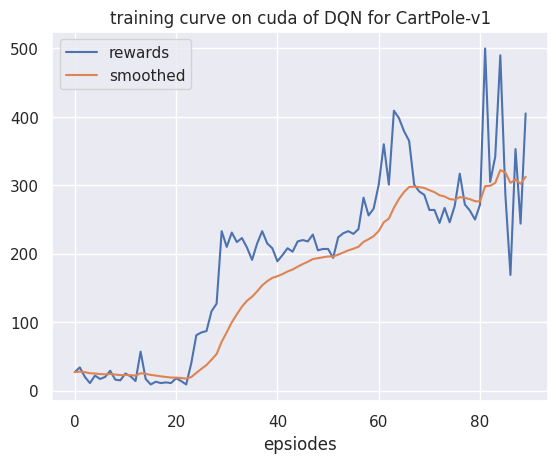

开始测试并录制视频！
回合：1/20，奖励：365.00


/root/shared-nvme/RL_learn/.venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /root/shared-nvme/RL_learn/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


回合：2/20，奖励：365.00
回合：3/20，奖励：365.00
回合：4/20，奖励：365.00
回合：5/20，奖励：365.00
回合：6/20，奖励：365.00
回合：7/20，奖励：365.00
回合：8/20，奖励：365.00
回合：9/20，奖励：365.00
回合：10/20，奖励：365.00
回合：11/20，奖励：365.00
回合：12/20，奖励：365.00
回合：13/20，奖励：365.00
回合：14/20，奖励：365.00
回合：15/20，奖励：365.00
回合：16/20，奖励：365.00
回合：17/20，奖励：365.00
回合：18/20，奖励：365.00
回合：19/20，奖励：365.00


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM default


回合：20/20，奖励：365.00
完成测试与录制
视频文件：./videos/dqn-test-episode-19.mp4


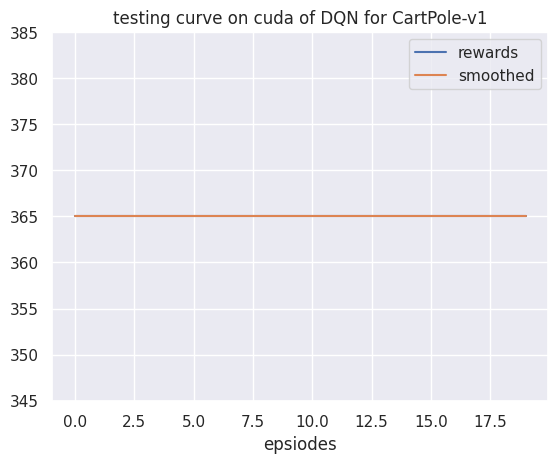

In [31]:
# 获取参数
cfg = get_args() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test_and_record(cfg, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果